<a href="https://colab.research.google.com/github/anjalirj27/UDAI-DATA-HACKATHON/blob/main/Mergedataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df_enroll = pd.read_csv("/content/enrol_final.csv")
df_bio = pd.read_csv("/content/bio_final.csv")
df_demo = pd.read_csv("/content/demo_final.csv")
print(df_enroll.shape)
print(df_bio.shape)
print(df_demo.shape)

(277868, 7)
(1765631, 6)
(958662, 6)


In [ ]:
print(df_enroll.head())
print(df_bio.head())
print(df_demo.head())

         date          state          district  pincode  age_0_5  age_5_17  \
0  2025-03-02      Meghalaya  east khasi hills   793121       11        61   
1  2025-03-09      Karnataka   bengaluru urban   560043       14        33   
2  2025-03-09  Uttar Pradesh      kanpur nagar   208001       29        82   
3  2025-03-09  Uttar Pradesh           aligarh   202133       62        29   
4  2025-03-09      Karnataka   bengaluru urban   560016       14        16   

   adult_count_enrol  
0                 37  
1                 39  
2                 12  
3                 15  
4                 21  
         date              state      district  pincode  bio_age_5_17  \
0  2025-03-01            Haryana  Mahendragarh   123029           280   
1  2025-03-01              Bihar     Madhepura   852121           144   
2  2025-03-01  Jammu And Kashmir         Punch   185101           643   
3  2025-03-01              Bihar       Bhojpur   802158           256   
4  2025-03-01         Tamil 

In [ ]:
import pandas as pd

# 1. Standardize and Calculate Totals
# Assuming 'bio', 'demo', and 'enrol' are your loaded DataFrames
df_bio['total_bio'] = df_bio['bio_age_5_17'] + df_bio['adult_count_bio']
df_demo['total_demo'] = df_demo['demo_age_5_17'] + df_demo['adult_count_demo']
df_enroll['total_enrol'] = df_enroll['age_0_5'] + df_enroll['age_5_17'] + df_enroll['adult_count_enrol']

# 2. Aggregate by Pincode
pincode_bio = df_bio.groupby(['state', 'district', 'pincode'])['total_bio'].sum().reset_index()
pincode_demo = df_demo.groupby(['state', 'district', 'pincode'])['total_demo'].sum().reset_index()
pincode_enrol = df_enroll.groupby(['state', 'district', 'pincode'])['total_enrol'].sum().reset_index()

# 3. Merge into a Master Performance Table
master_pincode = pincode_bio.merge(pincode_demo, on=['state', 'district', 'pincode'], how='outer') \
                            .merge(pincode_enrol, on=['state', 'district', 'pincode'], how='outer')

# Fill missing values with 0 so the math works
master_pincode = master_pincode.fillna(0)
master_pincode['total_activity'] = master_pincode['total_bio'] + master_pincode['total_demo'] + master_pincode['total_enrol']

# 4. Logic to Deduce the Reason for Low Performance
def categorize_station(row):
    # Case 1: Likely Equipment Failure (High Demo activity, but ZERO Biometrics)
    if row['total_demo'] > 50 and row['total_bio'] == 0:
        return "Possible Equipment Failure (No Bio)"

    # Case 2: Saturated Population (High Update activity, but ZERO New Enrollments)
    if row['total_enrol'] == 0 and (row['total_bio'] > 100 or row['total_demo'] > 100):
        return "Saturated Population (Updates Only)"

    # Case 3: Inactive/Dead Station (Extremely low activity across the board)
    if 0 < row['total_activity'] < 5:
        return "Underperforming/Dead Station"

    return "Normal / Active"

master_pincode['status'] = master_pincode.apply(categorize_station, axis=1)

# 5. Review Results
print(master_pincode['status'].value_counts())

# Filter for the anomalies you want to investigate
anomalies = master_pincode[master_pincode['status'] != "Normal / Active"]

status
Saturated Population (Updates Only)    23391
Possible Equipment Failure (No Bio)    22900
Normal / Active                         9088
Underperforming/Dead Station            5404
Name: count, dtype: int64


In [ ]:
master_pincode.shape

(60783, 8)

<Figure size 1500x800 with 0 Axes>

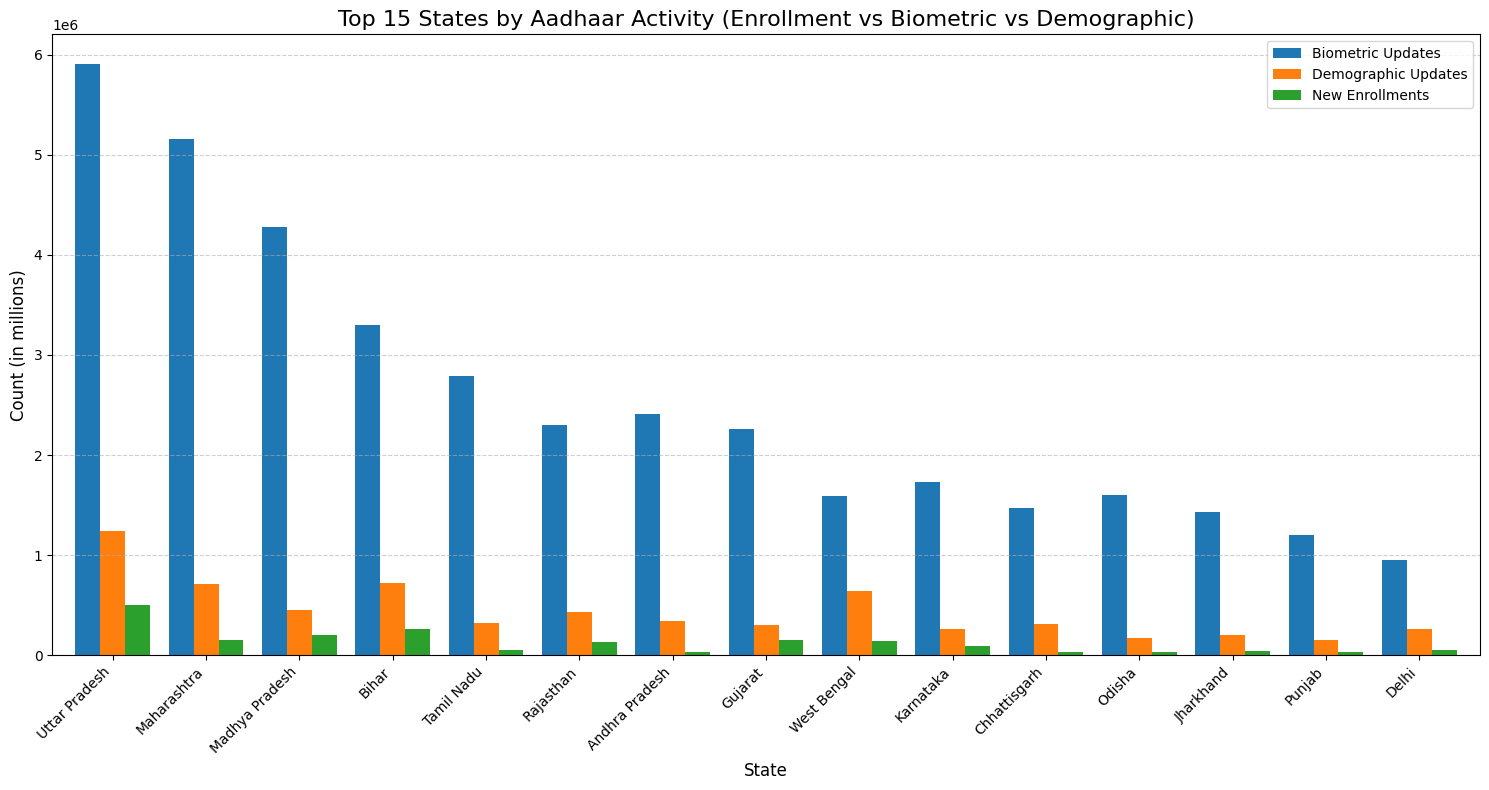

State summary saved to 'state_performance_summary.csv'


In [ ]:
# 3. Calculate Activity Totals for each category
df_bio['Total_Bio'] = df_bio['bio_age_5_17'] + df_bio['adult_count_bio']
df_demo['Total_Demo'] = df_demo['demo_age_5_17'] + df_demo['adult_count_demo']
df_enroll['Total_Enrol'] = df_enroll['age_0_5'] + df_enroll['age_5_17'] + df_enroll['adult_count_enrol']

# 4. Aggregate by State (Summarizing performance)
state_bio = df_bio.groupby('state')['Total_Bio'].sum().reset_index()
state_demo = df_demo.groupby('state')['Total_Demo'].sum().reset_index()
state_enrol = df_enroll.groupby('state')['Total_Enrol'].sum().reset_index()

# 5. Merge all metrics into one DataFrame
merged_state_data = state_bio.merge(state_demo, on='state', how='outer') \
                             .merge(state_enrol, on='state', how='outer')

# Fill missing values with 0
merged_state_data = merged_state_data.fillna(0)

# Calculate combined activity to find top performers
merged_state_data['Total_Activity'] = (merged_state_data['Total_Bio'] +
                                       merged_state_data['Total_Demo'] +
                                       merged_state_data['Total_Enrol'])

# Sort and pick top 15 states for a clean graph
top_15_states = merged_state_data.sort_values(by='Total_Activity', ascending=False).head(15)

# 6. Generate the Bar Graph
plt.figure(figsize=(15, 8))

# Setting the index to 'state' makes plotting grouped bars easier
top_15_states.set_index('state')[['Total_Bio', 'Total_Demo', 'Total_Enrol']].plot(
    kind='bar',
    figsize=(15, 8),
    width=0.8,
    color=['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green
)

plt.title('Top 15 States by Aadhaar Activity (Enrollment vs Biometric vs Demographic)', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Count (in millions)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(['Biometric Updates', 'Demographic Updates', 'New Enrollments'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot in Colab
plt.show()

# 7. Optional: Save the summary for reporting
merged_state_data.to_csv('state_performance_summary.csv', index=False)
print("State summary saved to 'state_performance_summary.csv'")

In [ ]:
merged_state_data.head()

,state,Total_Bio,Total_Demo,Total_Enrol,Total_Activity
0,Andaman And Nicobar Islands,18257.0,0.0,0.0,18257.0
1,Andaman and Nicobar Islands,0.0,3557.0,138.0,3695.0
2,Andhra Pradesh,3320455.0,1126769.0,38248.0,4485472.0
3,Arunachal Pradesh,64226.0,18059.0,1834.0,84119.0
4,Assam,824497.0,488905.0,143305.0,1456707.0


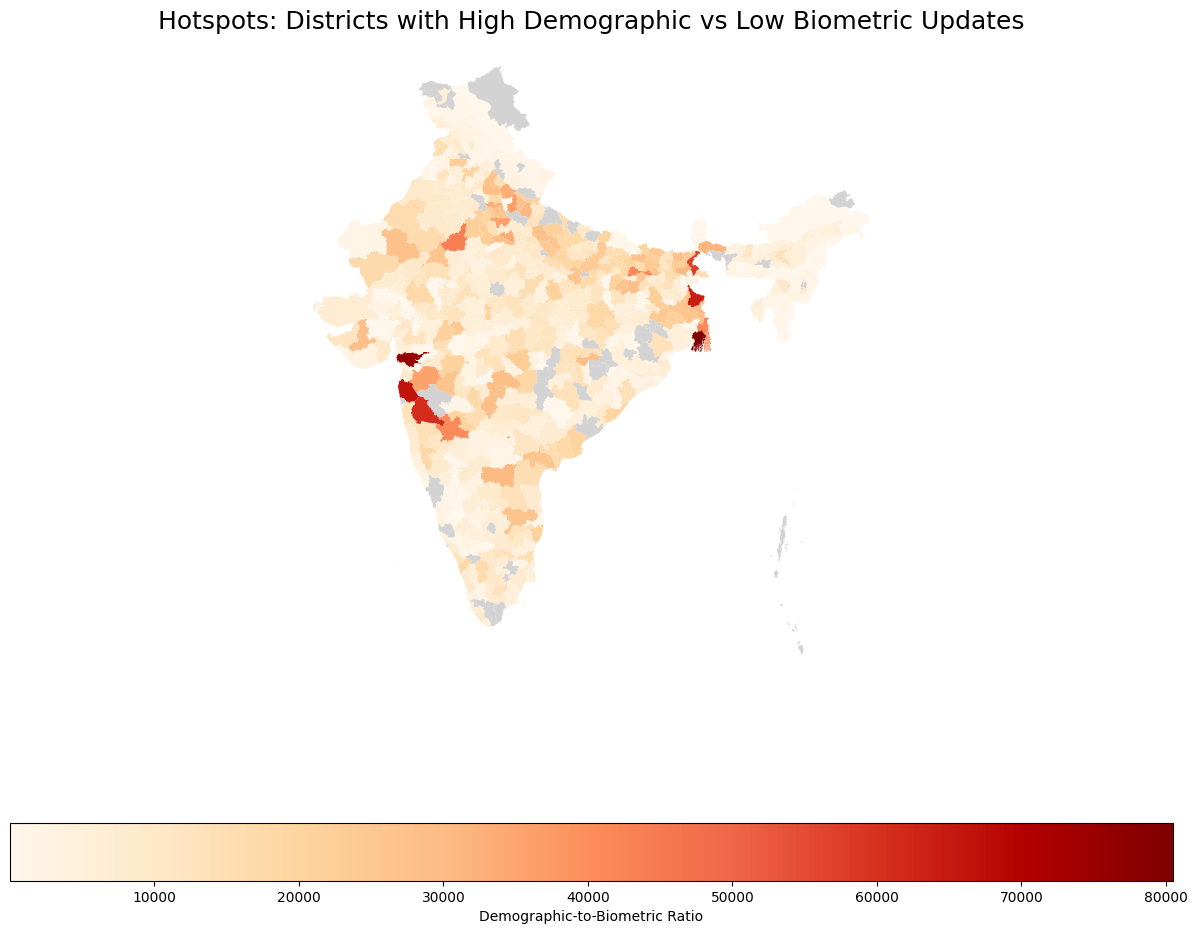

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare your data (using the merged dataframe from earlier)
# We will map the 'demo_to_bio_ratio' to highlight potential equipment issues
dist_bio = df_bio.groupby(['state', 'district'])['total_bio'].sum().reset_index()
dist_demo = df_demo.groupby(['state', 'district'])['total_demo'].sum().reset_index()
map_data = dist_demo.merge(dist_bio, on=['state', 'district'], how='left').fillna(0)

# Calculate anomaly score (Ratio of Demo updates vs Bio updates)
map_data['anomaly_score'] = map_data['total_demo'] / (map_data['total_bio'] + 1)

# 2. Download and Load India District GeoJSON
# This is a community-maintained GeoJSON file for Indian districts
geojsoN_url = "/content/india_district.geojson"
india_districts = gpd.read_file(geojsoN_url) # Corrected typo: geojson_url to geojsoN_url

# 3. Standardize names for merging
# Geographic files often use different cases or spellings
# Changed 'DISTRICT' to 'NAME_2' as 'DISTRICT' caused a KeyError.
# If 'NAME_2' is incorrect, please inspect india_districts.columns to find the right name.
india_districts['district'] = india_districts['NAME_2'].str.upper().str.strip()
map_data['district'] = map_data['district'].str.upper().str.strip()

# 4. Merge GeoData with UIDAI Data
merged_map = india_districts.merge(map_data, on='district', how='left')

# 5. Plot the Heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
ax.set_title('Hotspots: Districts with High Demographic vs Low Biometric Updates', fontsize=18)

# Plotting the anomaly score
# Areas in dark red indicate high demographic updates but low biometric facilities
merged_map.plot(column='anomaly_score',
                ax=ax,
                cmap='OrRd',
                legend=True,
                legend_kwds={'label': "Demographic-to-Biometric Ratio", 'orientation': "horizontal"},
                missing_kwds={'color': 'lightgrey'}) # Grey indicates no data for that district

plt.show()

1. Large States = Large Variance

States like Uttar Pradesh, Bihar, Maharashtra, Rajasthan, Madhya Pradesh show:

High variation across districts

Strong dependency on district-level socio-economic conditions

Urban centers skewing averages upward

👉 This suggests aggregation at state level hides district-level realities.



2. Small UTs Showing Disproportionate Variation

Examples:

Puducherry

Daman and Diu

Dadra & Nagar Haveli

Despite fewer records:

Small changes cause large statistical swings

Data sparsity amplifies variance

👉 These states are statistically fragile and should be analyzed with caution.


3. Biometric vs Enrollment Mismatch

In multiple states (notably Bihar, West Bengal, Uttar Pradesh):

High biometric activity does not always correspond to high enrollment

Indicates possible:

Dropouts after biometric capture

Migration effects

Data reporting delays

⚠️ This is a systemic red flag for policy effectiveness.



4. Urban-Centric Spikes

States with major metros (Maharashtra, Tamil Nadu, Karnataka):

Urban districts create sharp peaks

Rural districts pull averages down

Leads to high standard deviation even when averages look “healthy”



🚩 Irregularities & Data Quality Signals
⚠️ Missing / Partial Data

Daman and Diu lacks biometric variance but shows demographic variation

Indicates incomplete integration across datasets

⚠️ Date Format Inconsistency

Enrollment dataset uses DD-MM-YYYY

Others use YYYY-MM-DD

👉 Can cause silent errors in time-series or joins.

⚠️ State Naming Variants

Merged UT names create grouping distortion

Example: “Dadra and Nagar Haveli and Daman and Diu”

In [ ]:
import pandas as pd

# 2. Aggregate at District Level
dist_bio = df_bio.groupby(['state', 'district'])['total_bio'].sum().reset_index()
dist_demo = df_demo.groupby(['state', 'district'])['total_demo'].sum().reset_index()
dist_enrol = df_enroll.groupby(['state', 'district'])['total_enrol'].sum().reset_index()

# Merge into one Master District Dataframe
master_dist = dist_bio.merge(dist_demo, on=['state', 'district'], how='outer') \
                       .merge(dist_enrol, on=['state', 'district'], how='outer').fillna(0)

# --- CATEGORY 1: Biometric Blackholes (Equipment Failure) ---
# Logic: High Demographic activity but ZERO Biometric updates
bio_blackholes = master_dist[(master_dist['total_demo'] > 100) & (master_dist['total_bio'] == 0)]

# --- CATEGORY 2: High Maintenance Zones (Saturation) ---
# Logic: High updates (Bio + Demo) but ZERO New Enrollments
saturated_districts = master_dist[(master_dist['total_enrol'] == 0) &
                                  ((master_dist['total_bio'] + master_dist['total_demo']) > 500)]

# --- CATEGORY 3: Age-Group Outliers (Adult Enrollment Anomalies) ---
# Re-aggregating enrollment by age to find where adults are enrolling more than children
age_dist = df_enroll.groupby(['state', 'district'])[['age_0_5', 'age_5_17', 'adult_count_enrol']].sum().reset_index()
adult_outliers = age_dist[age_dist['adult_count_enrol'] > (age_dist['age_0_5'] + age_dist['age_5_17'])]

# 3. Exporting Results
print(f"Found {len(bio_blackholes)} Biometric Blackholes.")
print(f"Found {len(saturated_districts)} Saturated (Maintenance-only) Districts.")
print(f"Found {len(adult_outliers)} Districts with Adult Enrollment Anomalies.")

# Saving all to a single Excel file with different sheets for your report
with pd.ExcelWriter('UIDAI_Anomaly_Report.xlsx') as writer:
    bio_blackholes.to_excel(writer, sheet_name='Biometric_Blackholes', index=False)
    saturated_districts.to_excel(writer, sheet_name='Saturated_Districts', index=False)
    adult_outliers.to_excel(writer, sheet_name='Adult_Enrollment_Outliers', index=False)

print("\nDetailed report saved to 'UIDAI_Anomaly_Report.xlsx'")

Found 856 Biometric Blackholes.
Found 860 Saturated (Maintenance-only) Districts.
Found 4 Districts with Adult Enrollment Anomalies.

Detailed report saved to 'UIDAI_Anomaly_Report.xlsx'


In [ ]:
print(bio_blackholes)

                            state                    district  total_bio  \
5     Andaman and Nicobar Islands                    andamans        0.0   
6     Andaman and Nicobar Islands                     nicobar        0.0   
8     Andaman and Nicobar Islands    north and middle andaman        0.0   
9     Andaman and Nicobar Islands               south andaman        0.0   
55                 Andhra Pradesh                    adilabad        0.0   
...                           ...                         ...        ...   
1972                  West Bengal           south 24 parganas        0.0   
1973                  West Bengal              south dinajpur        0.0   
1975                  West Bengal  south twenty four parganas        0.0   
1976                  West Bengal              uttar dinajpur        0.0   
1978                  West Bengal              west midnapore        0.0   

      total_demo  total_enrol  
5          363.0         14.0  
6          394.0       

In [ ]:
bio_blackholes['state'].nunique()

38

In [ ]:
# Group by state and count the number of biometric blackholes per state
state_bio_blackholes = bio_blackholes['state'].value_counts().reset_index()
state_bio_blackholes.columns = ['State', 'Count of Biometric Blackholes']

print("Count of Biometric Blackholes per State:")
print(state_bio_blackholes)

Count of Biometric Blackholes per State:
                                       State  Count of Biometric Blackholes
0                              Uttar Pradesh                             82
1                             Madhya Pradesh                             60
2                                Maharashtra                             51
3                                  Karnataka                             49
4                                      Bihar                             44
5                             Andhra Pradesh                             43
6                                  Rajasthan                             43
7                                 Tamil Nadu                             41
8                                    Gujarat                             39
9                               Chhattisgarh                             38
10                                    Odisha                             38
11                                 Telangana   

In [ ]:
# Find common districts by merging bio_blackholes and saturated_districts
common_anomalous_districts = pd.merge(
    bio_blackholes[['state', 'district']],
    saturated_districts[['state', 'district']],
    on=['state', 'district'],
    how='inner'
)

print("Common Districts in both 'Biometric Blackholes' and 'Saturated Districts':")
print(common_anomalous_districts)


Common Districts in both 'Biometric Blackholes' and 'Saturated Districts':
                     state                district
0   Dadra And Nagar Haveli  dadra and nagar haveli
1            Daman And Diu                   daman
2        Jammu And Kashmir                anantnag
3        Jammu And Kashmir                  badgam
4        Jammu And Kashmir               bandipore
5        Jammu And Kashmir                baramula
6        Jammu And Kashmir                  budgam
7        Jammu And Kashmir                    doda
8        Jammu And Kashmir               ganderbal
9        Jammu And Kashmir                   jammu
10       Jammu And Kashmir                  kargil
11       Jammu And Kashmir                  kathua
12       Jammu And Kashmir                kishtwar
13       Jammu And Kashmir                  kulgam
14       Jammu And Kashmir                 kupwara
15       Jammu And Kashmir                     leh
16       Jammu And Kashmir                 pulwama
17     

In [ ]:
# Group by state and count the number of saturated districts per state
state_saturated_districts = saturated_districts['state'].value_counts().reset_index()
state_saturated_districts.columns = ['State', 'Count of Saturated Districts']

print("Count of Saturated Districts per State:")
print(state_saturated_districts)

Count of Saturated Districts per State:
                                       State  Count of Saturated Districts
0                              Uttar Pradesh                            79
1                             Madhya Pradesh                            59
2                                Maharashtra                            49
3                                  Karnataka                            48
4                          Jammu And Kashmir                            46
5                             Andhra Pradesh                            43
6                                 Tamil Nadu                            40
7                                      Bihar                            39
8                                     Odisha                            38
9                                  Telangana                            38
10                                 Rajasthan                            36
11                               West Bengal                